In [1]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

## **Préparation et combinaison des fichiers** 

In [1]:
fichiers_langues_europeennes = {
    "ted_talks_en.csv": "English",
    "ted_talks_es.csv": "Spanish",
    "ted_talks_fr.csv": "French",
    "ted_talks_it.csv": "Italian",
    "ted_talks_pt-br.csv": "Portuguese"
}

dataframes = []
colonnes_a_supprimer = ['talk_id', 'speaker_1' , 'all_speakers' , 'occupations' , 'about_speakers' , 'views' , 'recorded_date' , 'published_date' , 'event' , 'native_lang' , 'available_lang' , 'comments' , 'duration' , 'topics' , 'related_talks' , 'url' , 'description' , 'transcript',]  # Exemples
for fichier, langue in fichiers_langues_europeennes.items():
    df = pd.read_csv(fichier, encoding="utf-8")
    
    df = df.drop(columns=colonnes_a_supprimer, errors='ignore') 
    df = df.rename(columns={'title': 'texte'}) 
    
    df['Langue'] = langue
    
    dataframes.append(df)

fichier_combine = pd.concat(dataframes, ignore_index=True)

fichier_combine.to_csv("dataset_europeenne_.csv", index=False)

print("Les fichiers ont été combinés, les colonnes supprimées et renommées avec succès.")


Les fichiers ont été combinés, les colonnes supprimées et renommées avec succès.


In [2]:
fichier_multilingue = pd.read_csv("dataset.csv", encoding="utf-8")
dataset_europeen = pd.read_csv("dataset_europeenne_.csv", encoding="utf-8")

fichier_multilingue = fichier_multilingue.rename(columns={'Text': 'texte'})

langues_europeennes_alphabet_latin = ["Portugese", "Romanian", "Dutch", "French", "English", "Swedish", "Spanish", "Estonian", "Latin"]

fichier_europeen = fichier_multilingue[fichier_multilingue['language'].isin(langues_europeennes_alphabet_latin)]

fichier_europeen = fichier_europeen.rename(columns={'language': 'Langue'})

fichier_combine = pd.concat([fichier_europeen, dataset_europeen], ignore_index=True, axis=0)

fichier_combine.to_csv("dataset_europeen_combine.csv", index=False)

print(fichier_combine.head())  

print("Les fichiers ont été filtrés et combinés avec succès.")


                                               texte     Langue
0  klement gottwaldi surnukeha palsameeriti ning ...   Estonian
1  sebes joseph pereira thomas  på eng the jesuit...    Swedish
2  de spons behoort tot het geslacht haliclona en...      Dutch
3  müller mox figura centralis circulorum doctoru...      Latin
4  barocco pt escândalo de ª página é um filme fr...  Portugese
Les fichiers ont été filtrés et combinés avec succès.


### **lecture du fichier et affichage des colonnes existants**

In [3]:
dataset_europeen = pd.read_csv("dataset_europeene.csv", encoding="utf-8")
print(dataset_europeen.columns)


Index(['texte', 'Langue'], dtype='object')


### **Supression des valeurs nulles** 

In [4]:
dataset_europeen = dataset_europeen.dropna(subset=['texte'])

### **Convertir la colonne texte en miniscule**

In [5]:
dataset_europeen['texte'] = dataset_europeen['texte'].str.lower()

### **Supression des caractéres non alphabétiques**

In [6]:
dataset_europeen['texte'] = dataset_europeen['texte'].str.replace(r'[^a-zA-Z\s]', '', regex=True)


### **Dévision la colonne texte en tokens**

In [ ]:
nlp = spacy.load('en_core_web_sm')
dataset_europeen['tokens'] = dataset_europeen['texte'].apply(lambda x: [token.text for token in nlp(x)])

**Comptage le nombre de texte associé à chaque langue**

In [14]:
nbr_langue = dataset_europeen['Langue'].value_counts()
print(nbr_langue)


Langue
English       5005
Spanish       4921
French        4865
Portuguese    3901
Italian       3459
Estonian      1000
Dutch         1000
Swedish       1000
Romanian      1000
Name: count, dtype: int64


**Affichage le nombre de texte associé à chaque langue**

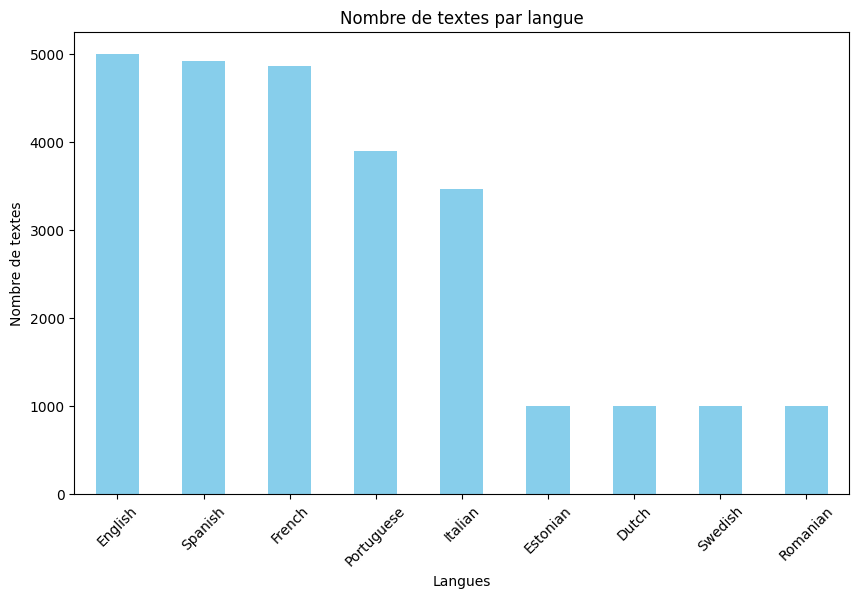

In [16]:
nbr_langue.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title("Nombre de textes par langue")
plt.xlabel("Langues")
plt.ylabel("Nombre de textes")
plt.xticks(rotation=45)
plt.show()


**Analyse de la Longueur des Textes**

In [22]:
def text_length_summary(dataset):
    dataset['text_length'] = dataset['texte'].apply(len)
    
    length_stats = dataset['text_length'].describe()
    return length_stats

length_stats = text_length_summary(dataset_europeen)
print(length_stats)


count    26151.000000
mean       125.904210
std        173.001443
min          0.000000
25%         40.000000
50%         54.000000
75%        139.000000
max       1314.000000
Name: text_length, dtype: float64


**Extraction tous les mots d'une langue spécifique**

In [28]:
def get_most_common_words(dataset, language):
    language_text = ' '.join(dataset[dataset['Langue'] == language]['texte'])
    word_counts = Counter(language_text.split())
    
    common_words = word_counts.most_common(10)
    return common_words

mots = get_most_common_words(dataset_europeen, 'French')
print(mots)


[('de', 5637), ('la', 3582), ('le', 2759), ('les', 2102), ('et', 2060), ('en', 1688), ('des', 1612), ('du', 1320), ('un', 1035), ('une', 940)]


**Affichage des textes courts avec moins de mots définis**

In [35]:
def display_short_sentences(dataset, min_words=2):
    dataset['word_count'] = dataset['texte'].apply(lambda x: len(x.split()))
    
    short_sentences = dataset[dataset['word_count'] < min_words]
    
    print(f"Nombre de lignes avec moins de {min_words} mots : {len(short_sentences)}")
    print(short_sentences[['texte', 'Langue', 'word_count']])

display_short_sentences(dataset_europeen, min_words=2)


Nombre de lignes avec moins de 2 mots : 20
               texte      Langue  word_count
5159                    Estonian           0
5789                       Dutch           0
7175     tembererana     English           1
7242          clonie     English           1
7365        genomics     English           1
8066         atheism     English           1
9344   rollercoaster     English           1
9421            awoo     English           1
9967          chasms     English           1
10458        accents     English           1
13423           awoo     Spanish           1
13958         chasms     Spanish           1
17341           awoo      French           1
17865          abmes      French           1
18680          labme      French           1
21116  rollercoaster     Italian           1
21181           awoo     Italian           1
24592  montanharussa  Portuguese           1
24669           awoo  Portuguese           1
25191        abismos  Portuguese           1


### **Suppression des ligne avec 2mots**

In [41]:
def remove_two_word_sentences(dataset):
    
    dataset['word_count'] = dataset['texte'].apply(lambda x: len(x.split()))
    
    dataset_cleaned = dataset[dataset['word_count'] != 2]
    dataset_cleaned = dataset_cleaned.drop(columns=['word_count'])
    
    return dataset_cleaned

dataset_europeen = remove_two_word_sentences(dataset_europeen)

print(dataset_europeen.head())


                                               texte    Langue  \
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian   
1  sebes joseph pereira thomas p eng the jesuits ...   Swedish   
2  de spons behoort tot het geslacht haliclona en...     Dutch   
3  association de recherche et de sauvegarde de l...    French   
4  dorota rabczewska artistinimega doda sndinud v...  Estonian   

                                              tokens  text_length  char_count  
0  [klement, gottwaldi, surnukeha, palsameeriti, ...          331         331  
1  [sebes, joseph, pereira, thomas, p, eng, the, ...          161         161  
2  [de, spons, behoort, tot, het, geslacht, halic...          175         175  
3  [association, de, recherche, et, de, sauvegard...          138         138  
4  [dorota, rabczewska, artistinimega, doda, sndi...          211         211  


In [45]:
print(dataset_europeen.head())

                                               texte    Langue  \
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian   
1  sebes joseph pereira thomas p eng the jesuits ...   Swedish   
2  de spons behoort tot het geslacht haliclona en...     Dutch   
3  association de recherche et de sauvegarde de l...    French   
4  dorota rabczewska artistinimega doda sndinud v...  Estonian   

                                              tokens  text_length  char_count  
0  [klement, gottwaldi, surnukeha, palsameeriti, ...          331         331  
1  [sebes, joseph, pereira, thomas, p, eng, the, ...          161         161  
2  [de, spons, behoort, tot, het, geslacht, halic...          175         175  
3  [association, de, recherche, et, de, sauvegard...          138         138  
4  [dorota, rabczewska, artistinimega, doda, sndi...          211         211  


In [47]:
print(dataset_europeen.columns)

Index(['texte', 'Langue', 'tokens', 'text_length', 'char_count'], dtype='object')


**Calcul le nombre de mots**

In [48]:
dataset_europeen['word_count'] = dataset_europeen['texte'].apply(lambda x: len(x.split()))

print(dataset_europeen.columns)

print(dataset_europeen[['texte', 'word_count']].head())


Index(['texte', 'Langue', 'tokens', 'text_length', 'char_count', 'word_count'], dtype='object')
                                               texte  word_count
0  klement gottwaldi surnukeha palsameeriti ning ...          43
1  sebes joseph pereira thomas p eng the jesuits ...          26
2  de spons behoort tot het geslacht haliclona en...          28
3  association de recherche et de sauvegarde de l...          19
4  dorota rabczewska artistinimega doda sndinud v...          33


**Affichage des lignes contenant 2 mots**

In [49]:
two_word_sentences = dataset_europeen[dataset_europeen['word_count'] == 2]

print(f"Nombre de lignes avec 2 mots : {len(two_word_sentences)}")
print(two_word_sentences[['texte', 'Langue', 'word_count']])


Nombre de lignes avec 2 mots : 0
Empty DataFrame
Columns: [texte, Langue, word_count]
Index: []


### **Vérification des doublons dans la colonne texte**

In [55]:
duplicates = dataset_europeen[dataset_europeen.duplicated(subset=['texte'])]
print(f"Nombre de doublons : {len(duplicates)}")

Nombre de doublons : 0


In [1]:
dataset_lemmatized = pd.read_csv("dataset_lemmatized.csv")
print(dataset_lemmatized.head())

                                               texte    Langue  \
0  klement gottwaldi surnukeha palsameeriti ning ...  estonian   
1  sebes joseph pereira thomas p eng the jesuits ...   swedish   
2  de spons behoort tot het geslacht haliclona en...     dutch   
3  association de recherche et de sauvegarde de l...    french   
4  dorota rabczewska artistinimega doda sndinud v...  estonian   

                                              tokens  text_length  char_count  \
0  ['klement', 'gottwaldi', 'surnukeha', 'palsame...          331         331   
1  ['sebes', 'joseph', 'pereira', 'thomas', 'p', ...          161         161   
2  ['de', 'spons', 'behoort', 'tot', 'het', 'gesl...          175         175   
3  ['association', 'de', 'recherche', 'et', 'de',...          138         138   
4  ['dorota', 'rabczewska', 'artistinimega', 'dod...          211         211   

   word_count                                    lemmatized_text  
0          43  klement gottwaldi surnukeha palsam

**Suppression des colonnes unitiles**

In [2]:
dataset_lemmatized = dataset_lemmatized.drop(columns=['lemmatized_text'])


In [3]:
print(dataset_lemmatized.head())

                                               texte    Langue  \
0  klement gottwaldi surnukeha palsameeriti ning ...  estonian   
1  sebes joseph pereira thomas p eng the jesuits ...   swedish   
2  de spons behoort tot het geslacht haliclona en...     dutch   
3  association de recherche et de sauvegarde de l...    french   
4  dorota rabczewska artistinimega doda sndinud v...  estonian   

                                              tokens  text_length  char_count  \
0  ['klement', 'gottwaldi', 'surnukeha', 'palsame...          331         331   
1  ['sebes', 'joseph', 'pereira', 'thomas', 'p', ...          161         161   
2  ['de', 'spons', 'behoort', 'tot', 'het', 'gesl...          175         175   
3  ['association', 'de', 'recherche', 'et', 'de',...          138         138   
4  ['dorota', 'rabczewska', 'artistinimega', 'dod...          211         211   

   word_count  
0          43  
1          26  
2          28  
3          19  
4          33  


In [5]:
dataset_lemmatized = dataset_lemmatized.drop(columns=['text_length', 'char_count', 'word_count'])
print(dataset_lemmatized.head())


                                               texte    Langue  \
0  klement gottwaldi surnukeha palsameeriti ning ...  estonian   
1  sebes joseph pereira thomas p eng the jesuits ...   swedish   
2  de spons behoort tot het geslacht haliclona en...     dutch   
3  association de recherche et de sauvegarde de l...    french   
4  dorota rabczewska artistinimega doda sndinud v...  estonian   

                                              tokens  
0  ['klement', 'gottwaldi', 'surnukeha', 'palsame...  
1  ['sebes', 'joseph', 'pereira', 'thomas', 'p', ...  
2  ['de', 'spons', 'behoort', 'tot', 'het', 'gesl...  
3  ['association', 'de', 'recherche', 'et', 'de',...  
4  ['dorota', 'rabczewska', 'artistinimega', 'dod...  


### **Comptage du nombre de textes par langue après suppression des doublons**

In [12]:
langue_counts = dataset_lemmatized['Langue'].value_counts()

print("Répartition des langues après suppression des doublons :")
print(langue_counts)


Répartition des langues après suppression des doublons :
Langue
dutch         2000
english       2000
estonian      2000
french        2000
italian       2000
portuguese    2000
romanian      2000
spanish       2000
swedish       2000
Name: count, dtype: int64


### **Equilibrage des données(Sous-échantillonnage et sur-échantillonnage)**

In [11]:
target_size = 2000

dataset_lemmatized = dataset_lemmatized.groupby('Langue', group_keys=False).apply(
    lambda x: x.sample(target_size, replace=(len(x) < target_size), random_state=42)
).reset_index(drop=True)

print(balanced_data['Langue'].value_counts())
print(f"Nombre total après équilibrage : {len(balanced_data)}")


Langue
dutch         2000
english       2000
estonian      2000
french        2000
italian       2000
portuguese    2000
romanian      2000
spanish       2000
swedish       2000
Name: count, dtype: int64
Nombre total après équilibrage : 18000


C:\Users\PLAYPHONE\AppData\Local\Temp\ipykernel_13776\4011221353.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset_lemmatized = dataset_lemmatized.groupby('Langue', group_keys=False).apply(


In [19]:
dataset_lemmatized['word_count'] = dataset_lemmatized['texte'].apply(lambda x: len(str(x).split()))


### **Supprission des lignes où le nombre de mots est égal à 1**


In [21]:
dataset_lemmatized = dataset_lemmatized[dataset_lemmatized['word_count'] > 1]

print(f"Nombre de lignes restantes après suppression : {len(dataset_lemmatized)}")


Nombre de lignes restantes après suppression : 17993


### **Vérification de l'équilibre des classes dans le dataset**


In [22]:
balance = dataset_lemmatized['Langue'].value_counts()
print(balance)


Langue
dutch         2000
italian       2000
swedish       2000
spanish       2000
romanian      2000
estonian      1999
french        1999
portuguese    1998
english       1997
Name: count, dtype: int64


In [28]:
dataset_lemmatized.head()

,texte,Langue,tokens
0,enispa flavitincta is een vlinder uit de famil...,dutch,"['enispa', 'flavitincta', 'is', 'een', 'vlinde..."
1,in waren reeds plannen gemaakt voor een natuur...,dutch,"['in', 'waren', 'reeds', 'plannen', 'gemaakt',..."
2,snijders paul je bent gedroomd enschede paul s...,dutch,"['snijders', 'paul', 'je', 'bent', 'gedroomd',..."
3,phaedrotoma laesa is een insect dat behoort to...,dutch,"['phaedrotoma', 'laesa', 'is', 'een', 'insect'..."
4,op september begon het vijfde seizoen bent van...,dutch,"['op', 'september', 'begon', 'het', 'vijfde', ..."


In [30]:
dataset_lemmatized.to_csv("donner_netoye.csv", index=False)


# **Transformation avec tf_idf**

In [2]:
dataset = pd.read_csv("donner_netoye.csv")

# Vérifier que la colonne 'tokens' existe
if 'tokens' not in dataset.columns:
    raise ValueError("La colonne 'tokens' est absente du dataset.")

# Étape 1 : Convertir les tokens en chaînes de texte
dataset['tokens_text'] = dataset['tokens'].apply(lambda x: " ".join(eval(x)) if isinstance(x, str) else "")

# Étape 2 : Instancier le vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  # Nombre maximum de termes
    ngram_range=(1, 2),  # Unigrammes et bigrammes
    sublinear_tf=True    # Pondération logarithmique
)

# Étape 3 : Appliquer le vectoriseur sur la colonne 'tokens_text'
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['tokens_text'])

# Étape 4 : Convertir la matrice TF-IDF en DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),  # Convertir la matrice sparse en array
    columns=tfidf_vectorizer.get_feature_names_out()  # Récupérer les noms des termes
)

# Ajouter la colonne 'Langue' pour conserver le contexte
tfidf_df['Langue'] = dataset['Langue']

# Étape 5 : Afficher un aperçu des résultats
print(tfidf_df.head())

# Facultatif : Enregistrer les données transformées dans un fichier CSV
tfidf_df.to_csv("tfidf2.csv", index=False)


    aa  aa cum  aabdel  aabdel jalil  aadressil  aafrika  aafrika phjaosas  \
0  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
1  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
2  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
3  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
4  0.0     0.0     0.0           0.0        0.0      0.0               0.0   

   aan  aan de  aan een  ...  zwart in  zweden  zweed  zweedse  zweeloo  \
0  0.0     0.0      0.0  ...       0.0     0.0    0.0      0.0      0.0   
1  0.0     0.0      0.0  ...       0.0     0.0    0.0      0.0      0.0   
2  0.0     0.0      0.0  ...       0.0     0.0    0.0      0.0      0.0   
3  0.0     0.0      0.0  ...       0.0     0.0    0.0      0.0      0.0   
4  0.0     0.0      0.0  ...       0.0     0.0    0.0      0.0      0.0   

   zwitser  zwitser simon  zwitserland  zwitserse  Langue  
0      0.0          

## **Application du labelEncoder pour convertir la colonne du langue en des nombres**

In [2]:
dataset = pd.read_csv("tfidf2.csv")

if 'Langue' not in dataset.columns:
    raise ValueError("La colonne 'Langue' est absente du dataset.")

# Instancier le LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le LabelEncoder sur la colonne 'Langue'
dataset['Langue_encoded'] = label_encoder.fit_transform(dataset['Langue'])

# Afficher les correspondances entre les langues et les valeurs numériques
print("Langues et leurs encodages :")
for langue, code in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{langue} => {code}")

# Afficher un aperçu du dataset
print(dataset.head())

Langues et leurs encodages :
dutch => 0
english => 1
estonian => 2
french => 3
italian => 4
portuguese => 5
romanian => 6
spanish => 7
swedish => 8
    aa  aa cum  aabdel  aabdel jalil  aadressil  aafrika  aafrika phjaosas  \
0  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
1  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
2  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
3  0.0     0.0     0.0           0.0        0.0      0.0               0.0   
4  0.0     0.0     0.0           0.0        0.0      0.0               0.0   

   aan  aan de  aan een  ...  zweden  zweed  zweedse  zweeloo  zwitser  \
0  0.0     0.0      0.0  ...     0.0    0.0      0.0      0.0      0.0   
1  0.0     0.0      0.0  ...     0.0    0.0      0.0      0.0      0.0   
2  0.0     0.0      0.0  ...     0.0    0.0      0.0      0.0      0.0   
3  0.0     0.0      0.0  ...     0.0    0.0      0.0      0.0      0.0   
4  0.0     0.

**Suppression des colonnes unitiles**

In [3]:
X = dataset.drop(columns=['Langue', 'Langue_encoded'])
y = dataset['Langue_encoded']  

### **Dimensions des deux mmatrices**

In [5]:
X.shape

(17993, 20000)

In [6]:
y.shape

(17993,)

## **Partitionnement des données en ensembles d'entraînement et de test**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
X_train.shape

(14394, 20000)

In [7]:
X_test.shape

(3599, 20000)

# **Application des modéles**

## **La regression de logistique** 

### **sans paramétres**

**Initialisation du modéle**

In [96]:
logreg = LogisticRegression()

**Entrainement du modéle**

In [97]:
logreg.fit(X_train, y_train)

LogisticRegression()

**calcul et affichage du score de train**

In [98]:
accuracy_train = logreg.score(X_train, y_train)

In [99]:
accuracy_train

0.9874947894956232

**Prédiction sur les données du tests** 

In [100]:
y_pred = logreg.predict(X_test)

In [101]:
accuracy = logreg.score(X_test, y_test)

In [102]:
accuracy

0.97304806890803

**Affichage de la matrice de confusion**

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.96      0.99      0.98       399
           2       1.00      0.98      0.99       400
           3       0.97      0.97      0.97       400
           4       0.93      0.94      0.94       400
           5       0.95      0.97      0.96       400
           6       0.99      0.99      0.99       400
           7       0.96      0.92      0.94       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



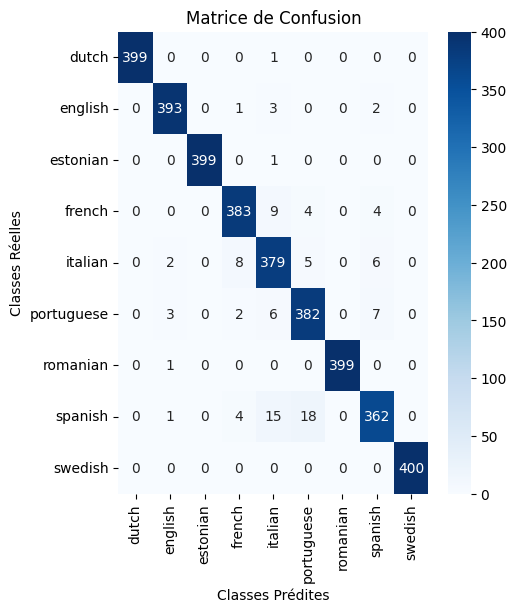

In [105]:
plt.figure(figsize=(5, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.title('Matrice de Confusion')
plt.show()

### **Avec hyperparamétres**

**Initialisation du modèle**

In [9]:
logistic_model = LogisticRegression( multi_class='multinomial')


**Configuration des hyperparamètres**

In [10]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        
    'max_iter': [100, 200, 300],        
}

**Configuration des hyperparamètres**

In [11]:
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')

In [12]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300]},
             scoring='accuracy')

**Affichage des meilleurs paramètres**

In [13]:
grid_search.best_params_

{'C': 10, 'max_iter': 100}

**Sélection du meilleur modèle et prédiction sur les données test**

In [14]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.98      0.98      0.98       399
           2       1.00      0.99      1.00       400
           3       0.97      0.97      0.97       400
           4       0.94      0.94      0.94       400
           5       0.95      0.95      0.95       400
           6       0.99      1.00      1.00       400
           7       0.95      0.93      0.94       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



In [16]:
accuracy_score(y_test, y_pred)

0.9747151986662962

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)

**Calcul,Affichage,Rapport de classification de la matrice de confusion**

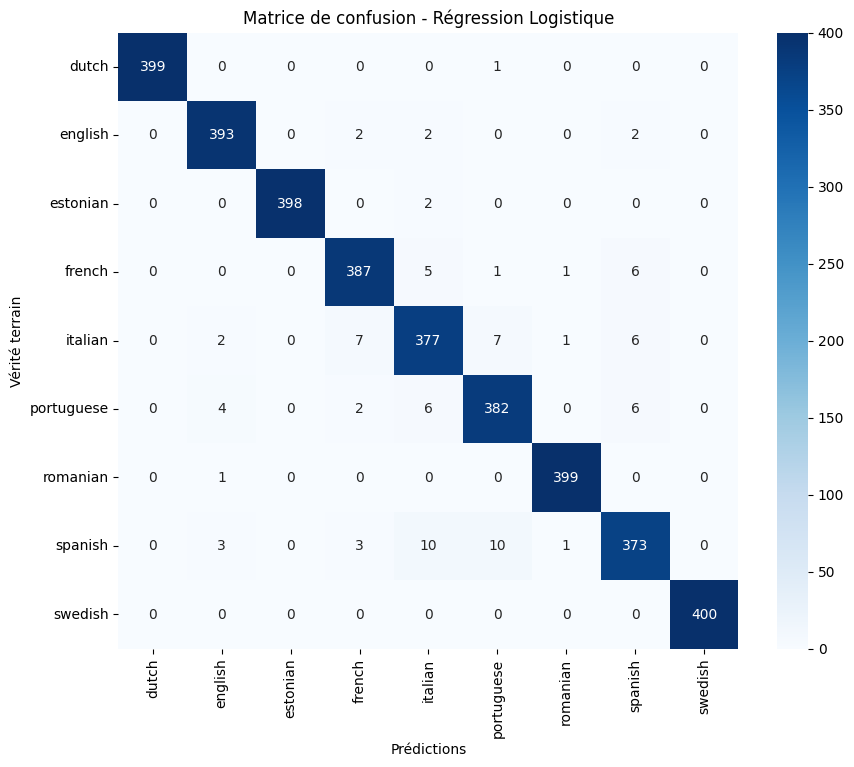

Rapport de classification :
              precision    recall  f1-score   support

       dutch       1.00      1.00      1.00       400
     english       0.98      0.98      0.98       399
    estonian       1.00      0.99      1.00       400
      french       0.97      0.97      0.97       400
     italian       0.94      0.94      0.94       400
  portuguese       0.95      0.95      0.95       400
    romanian       0.99      1.00      1.00       400
     spanish       0.95      0.93      0.94       400
     swedish       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



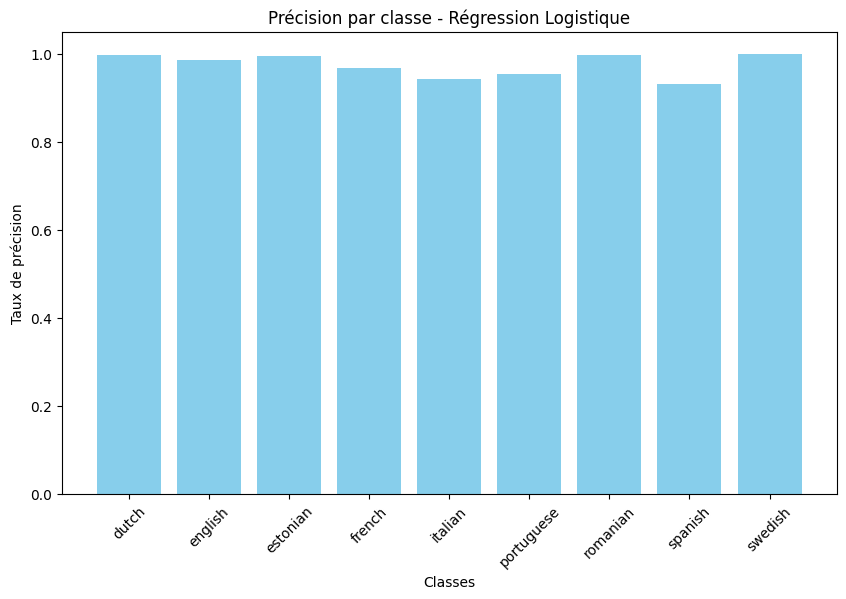

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion - Régression Logistique')
plt.show()
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(label_encoder.classes_, class_accuracies, color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Taux de précision")
plt.title("Précision par classe - Régression Logistique")
plt.xticks(rotation=45)
plt.show()

## **random_forest** 

### **sans parametres**

In [6]:
rf_model = RandomForestClassifier(random_state=42)

**Entrainement du modéle**

In [7]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Calcul et affichage du score de l'entrainement**

In [11]:
accuracy_train = rf_model.score(X_train, y_train)

In [12]:
accuracy_train

0.996178963456996

**prédiction du modéle sur les données du test**

In [13]:
y_pred = rf_model.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred)

In [15]:
accuracy

0.9672131147540983

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [16]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.97      0.97      0.97       399
           2       1.00      1.00      1.00       400
           3       0.97      0.94      0.95       400
           4       0.89      0.95      0.92       400
           5       0.93      0.95      0.94       400
           6       1.00      1.00      1.00       400
           7       0.95      0.90      0.92       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul,Affichage,Rapport de classification de la matrice de confusion**

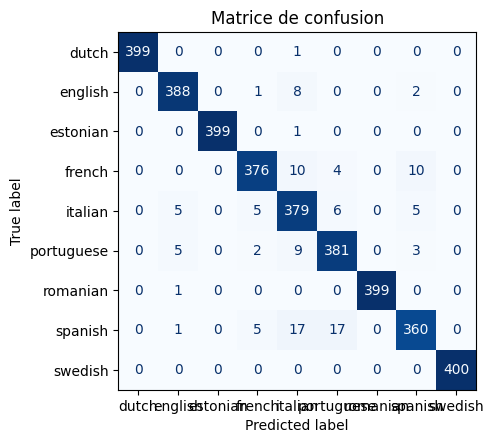

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(5, 5))  # Taille réduite
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

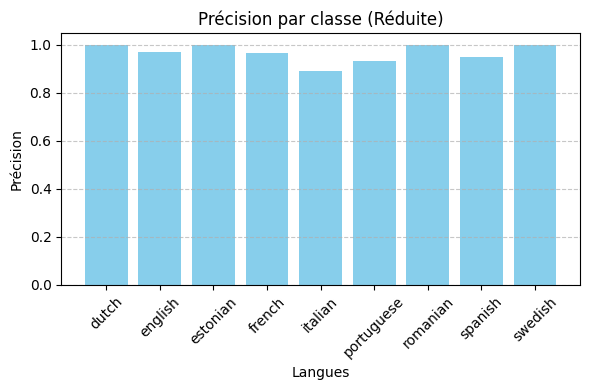

In [18]:
classification = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = {lang: classification[lang]["precision"] for lang in label_encoder.classes_}

# Affichage du graphe de précision
plt.figure(figsize=(6, 4))  # Taille réduite
plt.bar(precision_per_class.keys(), precision_per_class.values(), color="skyblue")
plt.title("Précision par classe (Réduite)")
plt.xlabel("Langues")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **avec hyperaparamétres**

**Initialisation du modèle**

In [10]:
random_forest = RandomForestClassifier(random_state=1)

**Configuration des hyperparamètres**

In [11]:
param_grid = {
    'max_depth': [25, 30, 35],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [5, 10, 15],
    'n_estimators': [300, 500, 700]
}

**Configuration des hyperparamètres**

In [12]:
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy'
)

**Entraînement de la recherche en grille sur les données d'entrainement**

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [25, 30, 35],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [300, 500, 700]},
             scoring='accuracy')

**Affichage des meilleurs paramètres**

In [14]:
grid_search.best_params_

{'max_depth': 35,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 700}

**Sélection du meilleur modèle et prédiction sur les données test**

In [15]:
best_rf = grid_search.best_estimator_

In [16]:
y_pred = best_rf.predict(X_test)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9508
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.94      0.94      0.94       399
           2       0.99      0.95      0.97       400
           3       0.98      0.92      0.94       400
           4       0.83      0.95      0.89       400
           5       0.88      0.95      0.92       400
           6       1.00      0.98      0.99       400
           7       0.96      0.88      0.92       400
           8       1.00      1.00      1.00       400

    accuracy                           0.95      3599
   macro avg       0.95      0.95      0.95      3599
weighted avg       0.95      0.95      0.95      3599



In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [19]:
print(conf_matrix)

[[394   0   0   3   2   1   0   0   0]
 [  0 377   1   0  19   1   0   1   0]
 [  0   8 382   1   8   1   0   0   0]
 [  0   4   0 366  12  13   0   5   0]
 [  0   3   1   3 379   6   0   8   0]
 [  0   0   0   0  18 382   0   0   0]
 [  0   7   0   0   0   2 391   0   0]
 [  0   2   0   2  18  26   0 352   0]
 [  0   1   0   0   0   0   0   0 399]]


**Calcul,Affichage,Rapport de classification de la matrice de confusion**

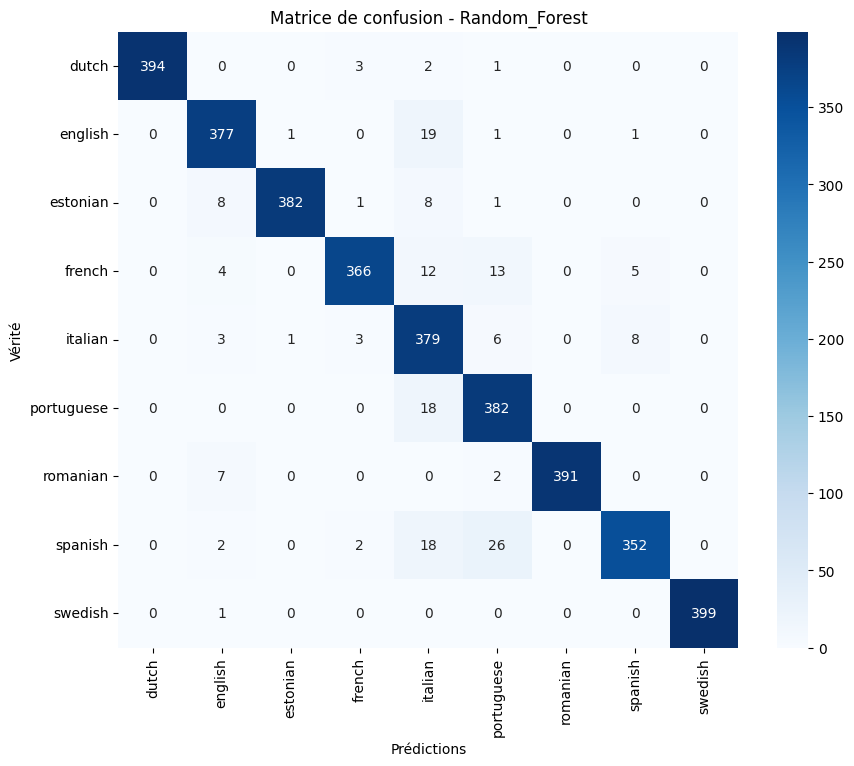

Rapport de classification :
              precision    recall  f1-score   support

       dutch       1.00      0.98      0.99       400
     english       0.94      0.94      0.94       399
    estonian       0.99      0.95      0.97       400
      french       0.98      0.92      0.94       400
     italian       0.83      0.95      0.89       400
  portuguese       0.88      0.95      0.92       400
    romanian       1.00      0.98      0.99       400
     spanish       0.96      0.88      0.92       400
     swedish       1.00      1.00      1.00       400

    accuracy                           0.95      3599
   macro avg       0.95      0.95      0.95      3599
weighted avg       0.95      0.95      0.95      3599



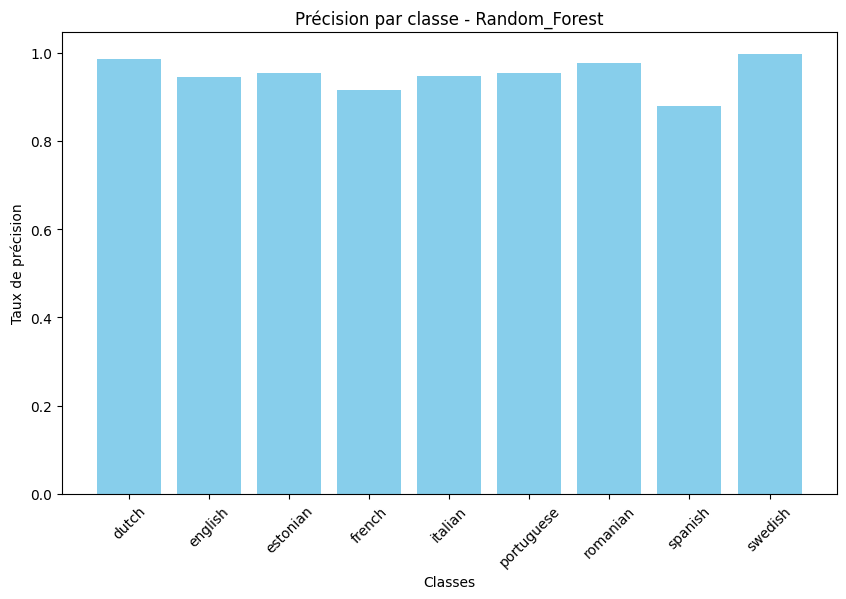

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité')
plt.title('Matrice de confusion - Random_Forest')
plt.show()
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(label_encoder.classes_, class_accuracies, color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Taux de précision")
plt.title("Précision par classe - Random_Forest")
plt.xticks(rotation=45)
plt.show()

## **SVM**

### **sans paramétres**

**initialisation du modéle**

In [19]:
svm_model = SVC()

**Entrainement du modéle**

In [20]:
svm_model.fit(X_train, y_train)

SVC()

**Prédiction du modéle sur les données du tests**

In [23]:
y_pred = svm_model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)

In [25]:
accuracy 

0.972770213948319

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [26]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.98      0.98      0.98       399
           2       1.00      0.99      1.00       400
           3       0.97      0.97      0.97       400
           4       0.93      0.94      0.94       400
           5       0.92      0.96      0.94       400
           6       1.00      0.99      1.00       400
           7       0.96      0.91      0.94       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul et affichage de la précision pour chaque classe**

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)

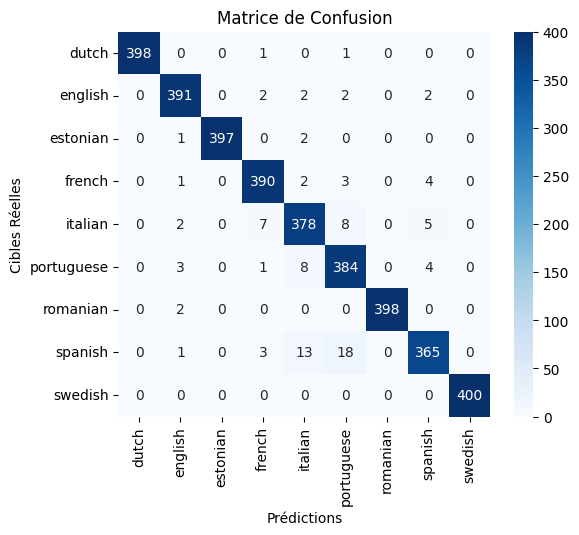

In [28]:
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Cibles Réelles")
plt.show()

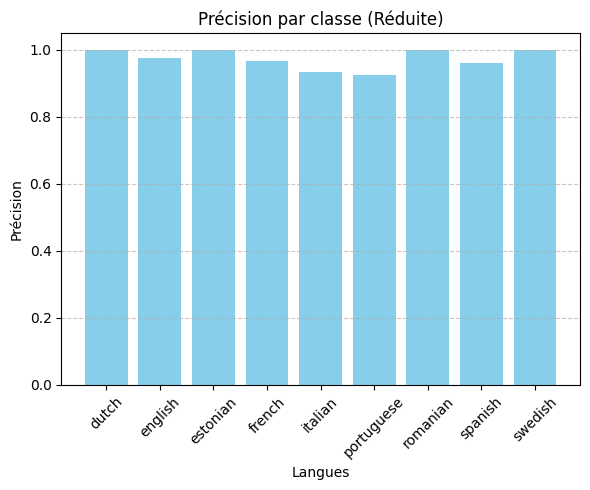

In [29]:
classification = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = {lang: classification[lang]["precision"] for lang in label_encoder.classes_}

# Affichage du graphe de précision
plt.figure(figsize=(6, 5))  # Taille réduite
plt.bar(precision_per_class.keys(), precision_per_class.values(), color="skyblue")
plt.title("Précision par classe (Réduite)")
plt.xlabel("Langues")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **avec hyperparamétres**

**Réduire dimensions pour accélérer l'entraînement**

In [83]:
pca = PCA(n_components=5000, random_state=42) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

**Initialisation du modèle**

In [84]:
svm_model = SVC()

**Configuration des hyperparamètres**

In [85]:
param_distributions = {
    'C': [ 2,3],        
    'kernel': ['linear', 'rbf'],   
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  
}

**Initialisation de la recherche en grille pour optimiser les hyperparamètres du modèle**

In [86]:
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_distributions,
    n_iter=10,  
    scoring='accuracy',
    cv=5,      
    random_state=42,
    n_jobs=-1   
)

**Entraînement de la recherche en grille sur les données d'entrainement**

In [87]:
random_search.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [2, 3],
                                        'gamma': ['scale', 'auto', 0.01, 0.1,
                                                  1],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='accuracy')

**Affichage des meilleurs paramètres**

In [88]:
random_search.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 2}

**Meilleure performance**

In [89]:
random_search.best_score_

np.float64(0.9676252829854395)

**Sélection du meilleur modèle et prédiction sur les données test**

In [90]:
best_svm_model = random_search.best_estimator_

In [91]:
y_pred = best_svm_model.predict(X_test_pca)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [92]:
print("Accuracy :", accuracy_score(y_test, y_pred))

Accuracy : 0.9713809391497639


In [93]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.98      0.98      0.98       399
           2       1.00      1.00      1.00       400
           3       0.96      0.96      0.96       400
           4       0.92      0.95      0.93       400
           5       0.93      0.95      0.94       400
           6       1.00      1.00      1.00       400
           7       0.95      0.91      0.93       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul,Affichage,Rapport de classification de la matrice de confusion**

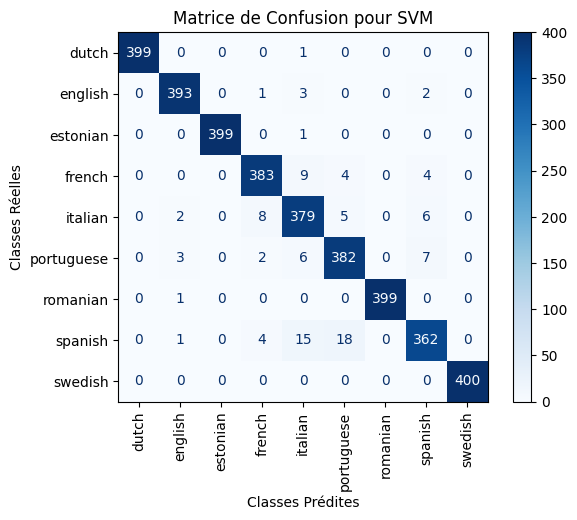

Rapport de Classification :
              precision    recall  f1-score   support

       dutch       1.00      1.00      1.00       400
     english       0.98      0.98      0.98       399
    estonian       1.00      1.00      1.00       400
      french       0.96      0.96      0.96       400
     italian       0.92      0.95      0.93       400
  portuguese       0.93      0.95      0.94       400
    romanian       1.00      1.00      1.00       400
     spanish       0.95      0.91      0.93       400
     swedish       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



In [94]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.ax_.set_title("Matrice de Confusion pour SVM")
disp.ax_.set_xlabel("Classes Prédites")
disp.ax_.set_ylabel("Classes Réelles")
plt.show()

print("Rapport de Classification :")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

**Calcul et affichage de la précision pour chaque classe**

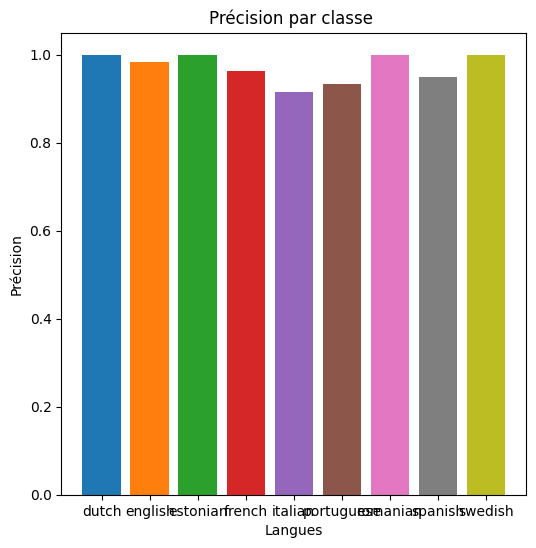

In [95]:
precision_per_class = precision_score(y_test, y_pred, average=None, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(6, 6))
plt.bar(range(len(label_encoder.classes_)), precision_per_class, color=plt.cm.tab10(range(len(label_encoder.classes_))))
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_)
plt.xlabel("Langues")
plt.ylabel("Précision")
plt.title("Précision par classe ")
plt.show()


## **Model K_means**

### **sans paramétres**

**Initialisation du modéle**

In [30]:
nb_model = MultinomialNB()


**entrainement du modéle**

In [31]:
nb_model.fit(X_train, y_train)

MultinomialNB()

**calcul et affichage du score de train**

In [32]:
accyracyt=nb_model.score(X_train, y_train)

In [33]:
accyracyt

0.9823537585104904

**Prédiction sur les données du tests**

In [34]:
y_pred = nb_model.predict(X_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred)

In [36]:
accuracy

0.9711030841900528

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [37]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.95      0.99      0.97       399
           2       1.00      0.96      0.98       400
           3       0.96      0.97      0.97       400
           4       0.97      0.94      0.95       400
           5       0.97      0.94      0.96       400
           6       1.00      0.99      0.99       400
           7       0.92      0.96      0.94       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul et affichage de la précision pour chaque classe**

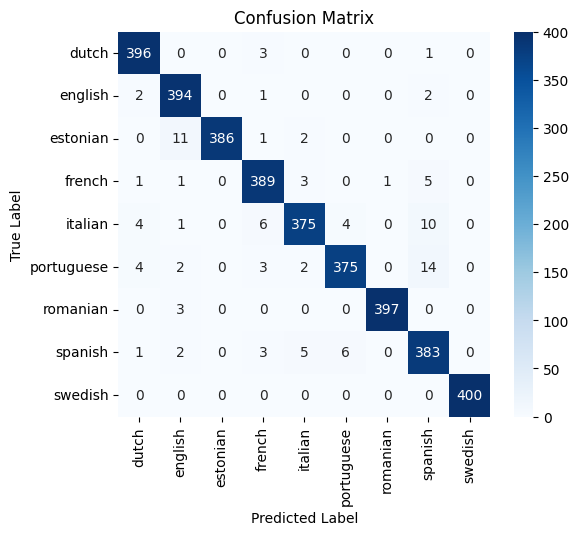

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

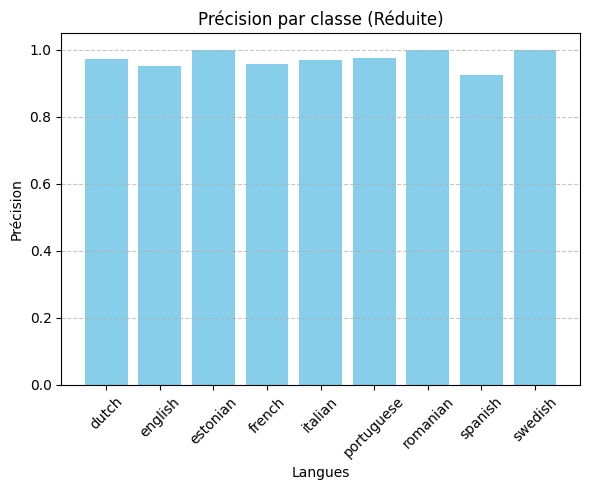

In [39]:
classification = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = {lang: classification[lang]["precision"] for lang in label_encoder.classes_}

# Affichage du graphe de précision
plt.figure(figsize=(6, 5))  # Taille réduite
plt.bar(precision_per_class.keys(), precision_per_class.values(), color="skyblue")
plt.title("Précision par classe (Réduite)")
plt.xlabel("Langues")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **avec hyperparamétres**

**Initialisation du modèle**

In [32]:
nb_model = MultinomialNB()


**Configuration des hyperparamètres**

In [33]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  
}

**Initialisation de la recherche en grille pour optimiser les hyperparamètres du modèle**

In [36]:
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#Entraînement de la recherche en grille sur les données d'entrainement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]},
             scoring='accuracy')

**Affichage des mailleurs paramètres**

In [37]:
 grid_search.best_params_

{'alpha': 1.0}

**Meilleure performance**

In [38]:
grid_search.best_score_

np.float64(0.9712380345947663)

**Sélection du meilleur modèle et prédiction sur les données test**

In [39]:
best_nb_model = grid_search.best_estimator_
y_pred = best_nb_model.predict(X_test)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [40]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9711030841900528


In [41]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.95      0.99      0.97       399
           2       1.00      0.96      0.98       400
           3       0.96      0.97      0.97       400
           4       0.97      0.94      0.95       400
           5       0.97      0.94      0.96       400
           6       1.00      0.99      0.99       400
           7       0.92      0.96      0.94       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul et affichage de la précision pour chaque classe**

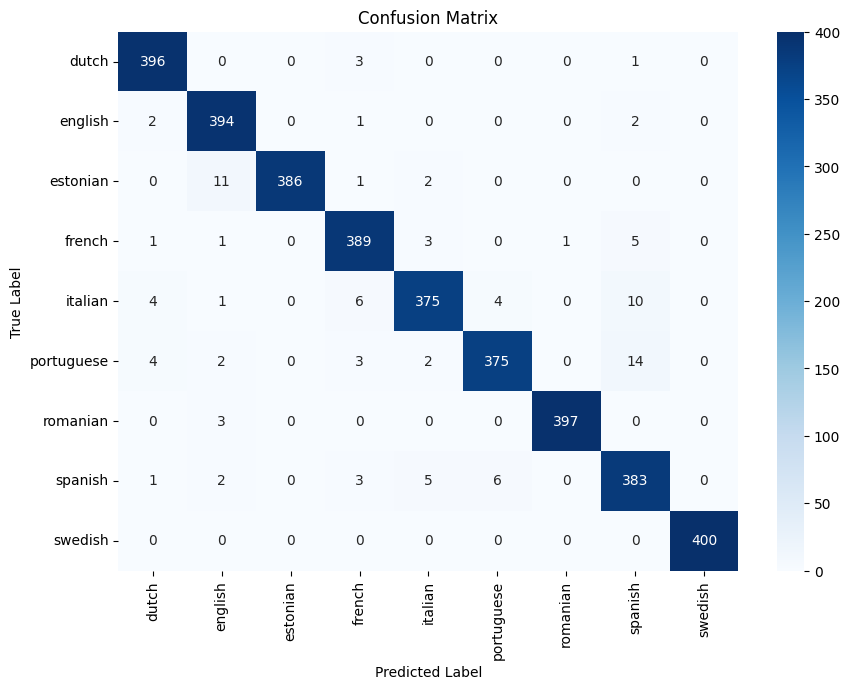

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

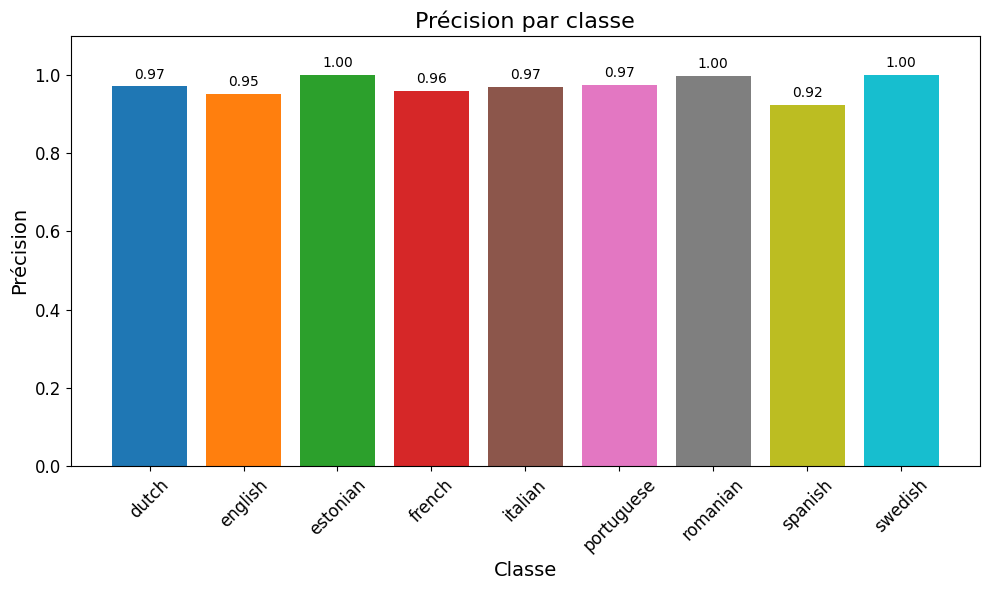

In [43]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

classes = list(report.keys())[:-3]  # Exclure 'accuracy', 'macro avg', 'weighted avg'
precisions = [report[cls]['precision'] for cls in classes]

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))  # Palette de couleurs
plt.bar(classes, precisions, color=colors)

plt.title("Précision par classe", fontsize=16)
plt.xlabel("Classe", fontsize=14)
plt.ylabel("Précision", fontsize=14)
plt.ylim(0, 1.1) 
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for i, precision in enumerate(precisions):
    plt.text(i, precision + 0.02, f"{precision:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## **light boost**

### **sans paramétres**

**Initialisation du modéle**

In [56]:
lgbm_model = LGBMClassifier()

**Entrainemant du modéle**

In [57]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52192
[LightGBM] [Info] Number of data points in the train set: 14394, number of used features: 2479
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.198059
[LightGBM] [Info] Start training from score -2.197433
[LightGBM] [Info] Start training from score -2.197433
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.198059
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier()

**calcul et affichage d'accuracy**

In [58]:
accuracyt=lgbm_model.score(X_train, y_train)

In [59]:
accuracyt

0.9855495345282757

**Prédiction sur les données de tests**

In [60]:
y_pred = lgbm_model.predict(X_test)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [61]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy : 0.9560989163656571
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.98      0.95      0.97       399
           2       1.00      0.99      0.99       400
           3       0.97      0.92      0.94       400
           4       0.84      0.94      0.89       400
           5       0.93      0.94      0.93       400
           6       1.00      0.99      1.00       400
           7       0.91      0.89      0.90       400
           8       1.00      1.00      1.00       400

    accuracy                           0.96      3599
   macro avg       0.96      0.96      0.96      3599
weighted avg       0.96      0.96      0.96      3599



**Calcul et affichage de la précision pour chaque classe**

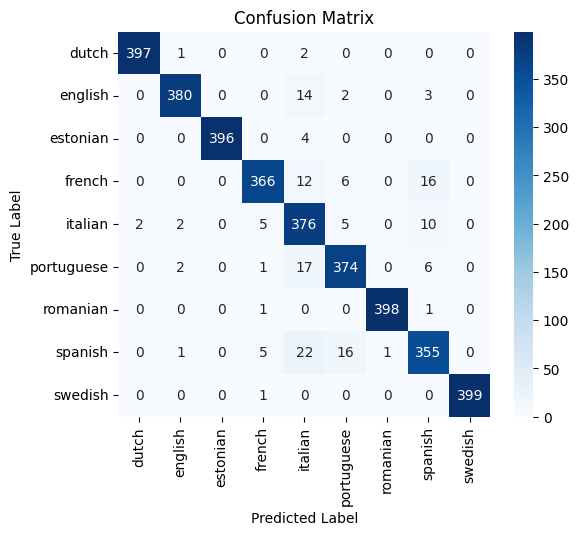

In [62]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

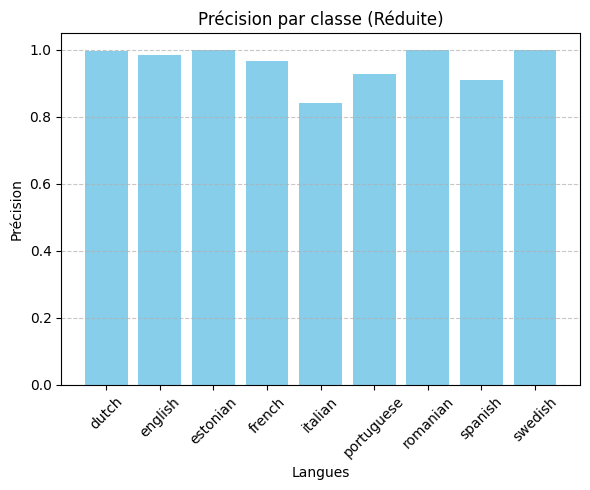

In [63]:
classification = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = {lang: classification[lang]["precision"] for lang in label_encoder.classes_}

# Affichage du graphe de précision
plt.figure(figsize=(6, 5))  # Taille réduite
plt.bar(precision_per_class.keys(), precision_per_class.values(), color="skyblue")
plt.title("Précision par classe (Réduite)")
plt.xlabel("Langues")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **avec hyperparamétres**

**Configuration des hyperparamètres**

In [40]:
param_distributions = {
    'num_leaves': [31, 50, 100], 
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

**Initialisation du modèle**

In [41]:
lgbm_model = LGBMClassifier()

**Configuration des hyperparamètres**

In [42]:
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=10,            
    scoring='accuracy',   
    cv=3,                 
    random_state=42,
    n_jobs=-1            
)

**Entraînement de la recherche en grille sur les données d'entrainement**

In [43]:
random_search.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52192
[LightGBM] [Info] Number of data points in the train set: 14394, number of used features: 2479
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.198059
[LightGBM] [Info] Start training from score -2.197433
[LightGBM] [Info] Start training from score -2.197433
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.198059
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Info] Start training from score -2.196808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

**Affichage des mailleurs paramètres**

In [44]:
random_search.best_params_

{'subsample': 0.8,
 'num_leaves': 50,
 'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6}

**Sélection du meilleur modèle et prédiction sur les données test**

In [45]:
y_pred = random_search.best_estimator_.predict(X_test)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [46]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy : 0.9585996110030564
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.98      0.95      0.97       399
           2       1.00      0.99      0.99       400
           3       0.98      0.91      0.94       400
           4       0.83      0.95      0.89       400
           5       0.93      0.95      0.94       400
           6       1.00      0.99      1.00       400
           7       0.92      0.89      0.91       400
           8       1.00      1.00      1.00       400

    accuracy                           0.96      3599
   macro avg       0.96      0.96      0.96      3599
weighted avg       0.96      0.96      0.96      3599



**Calcul et affichage de la précision pour chaque classe**

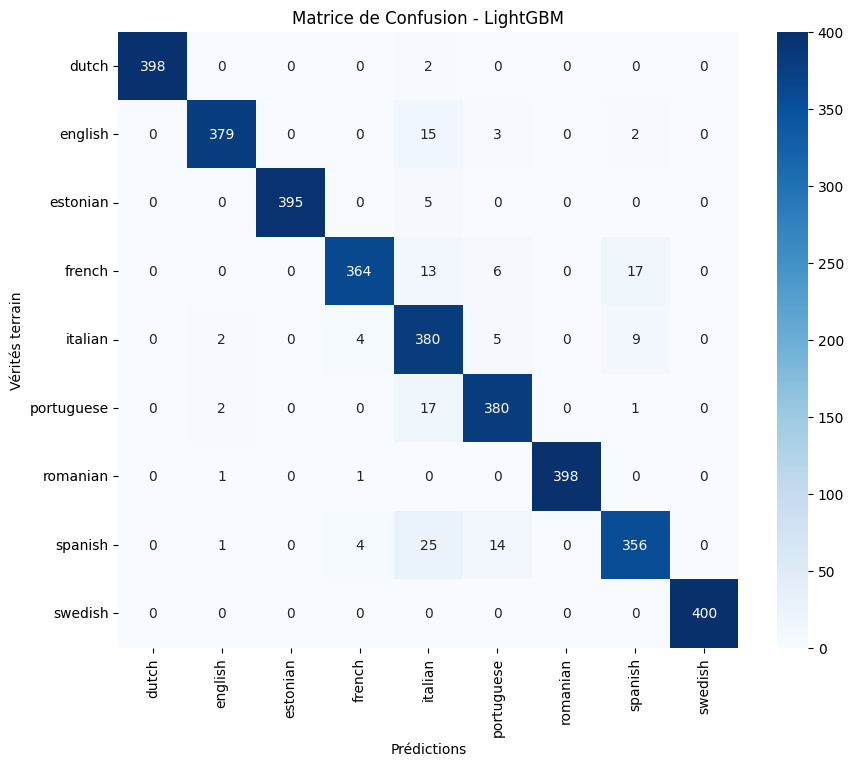

Classification Report:
              precision    recall  f1-score   support

       dutch       1.00      0.99      1.00       400
     english       0.98      0.95      0.97       399
    estonian       1.00      0.99      0.99       400
      french       0.98      0.91      0.94       400
     italian       0.83      0.95      0.89       400
  portuguese       0.93      0.95      0.94       400
    romanian       1.00      0.99      1.00       400
     spanish       0.92      0.89      0.91       400
     swedish       1.00      1.00      1.00       400

    accuracy                           0.96      3599
   macro avg       0.96      0.96      0.96      3599
weighted avg       0.96      0.96      0.96      3599



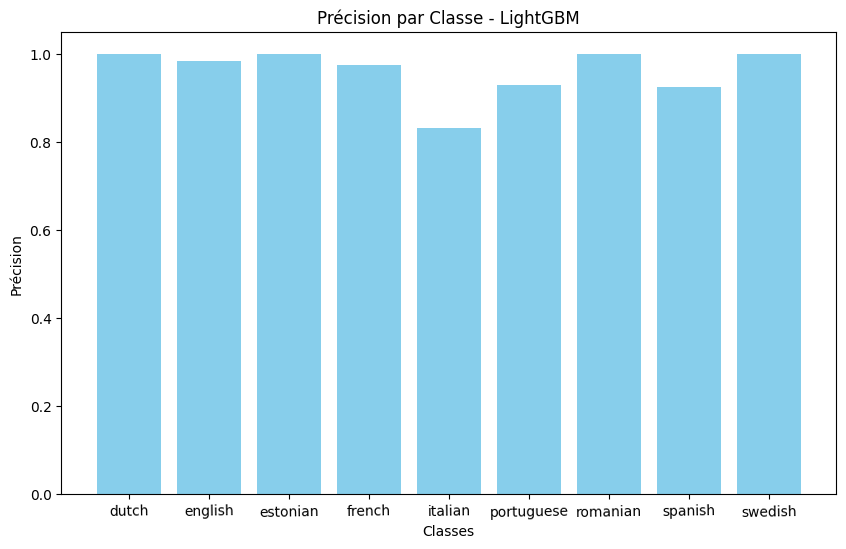

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de Confusion - LightGBM')
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
class_precisions = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)['weighted avg']['precision']
classes = label_encoder.classes_

# Visualisation de la précision par classe
plt.figure(figsize=(10, 6))
plt.bar(classes, [classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)[cls]['precision'] for cls in classes], color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Précision")
plt.title("Précision par Classe - LightGBM")
plt.xticks(rotation=1)
plt.show()

## **xgboost**

### **sans paramétres**

**initialisation du modèle**

In [48]:
xgb_model = xgb.XGBClassifier()

**entainement du modèle**

In [49]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**calcul et affichage de l'accuracy**

In [50]:
accuracyt=xgb_model.score(X_train, y_train)

In [51]:
accuracyt

0.9790885091010143

**Prédiction du modèle sur les données du tests**

In [52]:
y_pred = xgb_model.predict(X_test)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [53]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy : 0.9580439010836344
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.94      0.96       399
           2       1.00      0.99      0.99       400
           3       0.97      0.93      0.95       400
           4       0.91      0.92      0.92       400
           5       0.85      0.98      0.91       400
           6       0.99      0.99      0.99       400
           7       0.94      0.88      0.91       400
           8       1.00      1.00      1.00       400

    accuracy                           0.96      3599
   macro avg       0.96      0.96      0.96      3599
weighted avg       0.96      0.96      0.96      3599



**Calcul et affichage de la précision pour chaque classe**

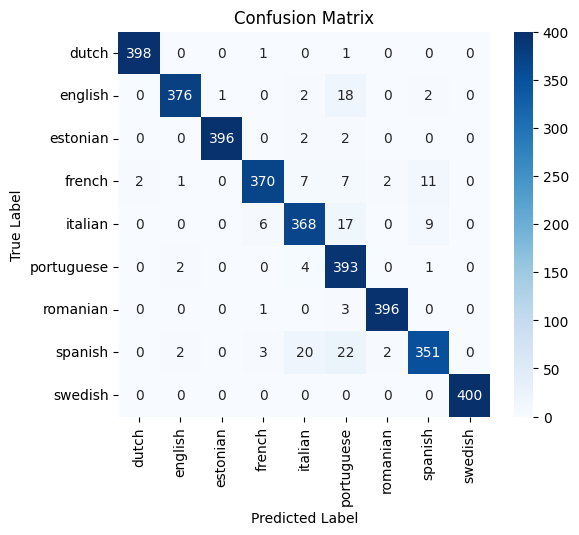

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

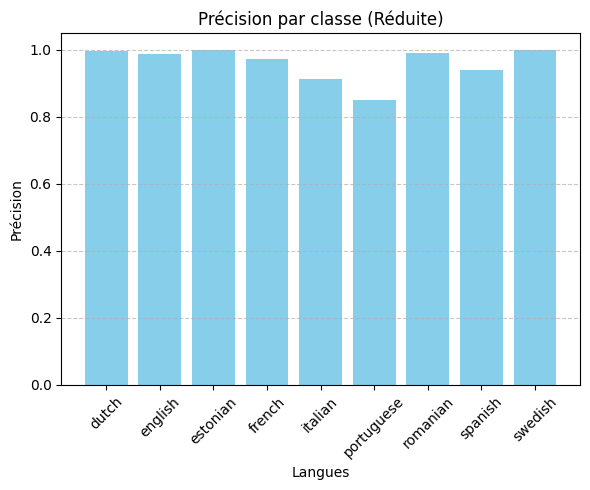

In [55]:
classification = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = {lang: classification[lang]["precision"] for lang in label_encoder.classes_}

# Affichage du graphe de précision
plt.figure(figsize=(6, 5))  # Taille réduite
plt.bar(precision_per_class.keys(), precision_per_class.values(), color="skyblue")
plt.title("Précision par classe (Réduite)")
plt.xlabel("Langues")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Avec hyperparamétres**

**Réduire les dimensions**

In [5]:
pca = PCA(n_components=200, random_state=42) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


**Initialisation du modèle**

In [8]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(y.unique()), 
    use_label_encoder=False,
    eval_metric='mlogloss'
)

**Configuration des hyperparamètres**

In [9]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

**Initialisation de la recherche en grille pour optimiser les hyperparamètres du modèle**

In [10]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=15, 
    scoring='accuracy',
    cv=3,  
    random_state=42,
    n_jobs=-1 
)

**Entraînement de la recherche en grille sur les données PCA réduites**

In [11]:
random_search.fit(X_train_pca, y_train)

C:\Users\PLAYPHONE\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=9, num_parallel_tree=None, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

**Meilleure performance**

In [12]:
random_search.best_score_

np.float64(0.9677643462553842)

**Affichage des meilleurs paramètres**

In [14]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 300,
 'max_depth': 5,
 'learning_rate': 0.2,
 'colsample_bytree': 0.8}

**Sélection du meilleur modèle et prédiction sur les données test**

In [15]:
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test_pca)

**Évaluation des performances du modèle  avec précision et rapport de classification**

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9753
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.98      0.99      0.99       399
           2       1.00      1.00      1.00       400
           3       0.96      0.97      0.96       400
           4       0.96      0.95      0.95       400
           5       0.95      0.95      0.95       400
           6       1.00      1.00      1.00       400
           7       0.94      0.92      0.93       400
           8       1.00      1.00      1.00       400

    accuracy                           0.98      3599
   macro avg       0.98      0.98      0.98      3599
weighted avg       0.98      0.98      0.98      3599



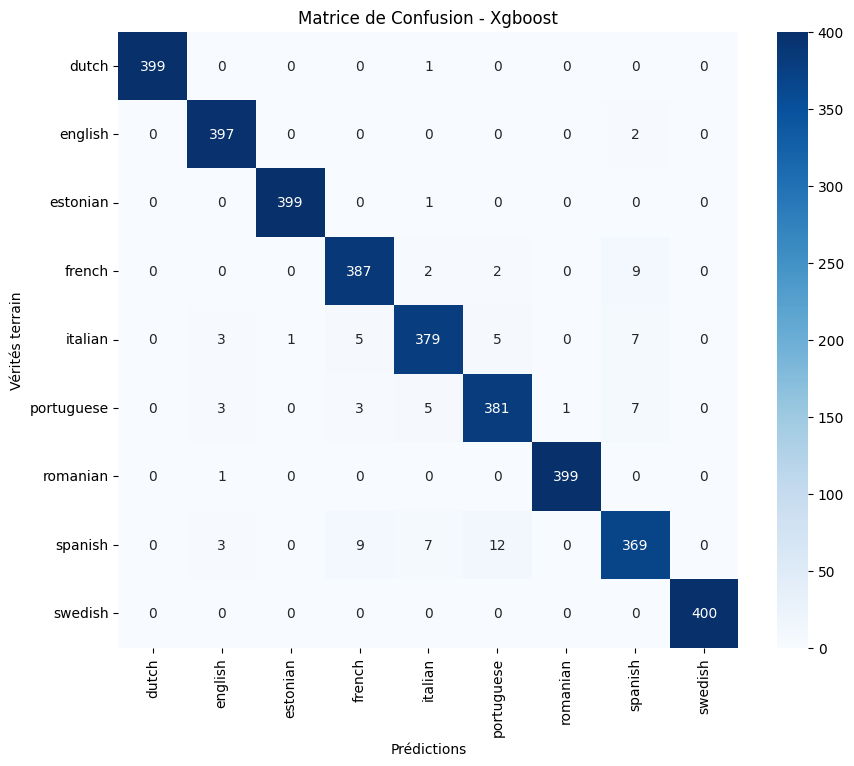

Classification Report:
              precision    recall  f1-score   support

       dutch       1.00      1.00      1.00       400
     english       0.98      0.99      0.99       399
    estonian       1.00      1.00      1.00       400
      french       0.96      0.97      0.96       400
     italian       0.96      0.95      0.95       400
  portuguese       0.95      0.95      0.95       400
    romanian       1.00      1.00      1.00       400
     spanish       0.94      0.92      0.93       400
     swedish       1.00      1.00      1.00       400

    accuracy                           0.98      3599
   macro avg       0.98      0.98      0.98      3599
weighted avg       0.98      0.98      0.98      3599



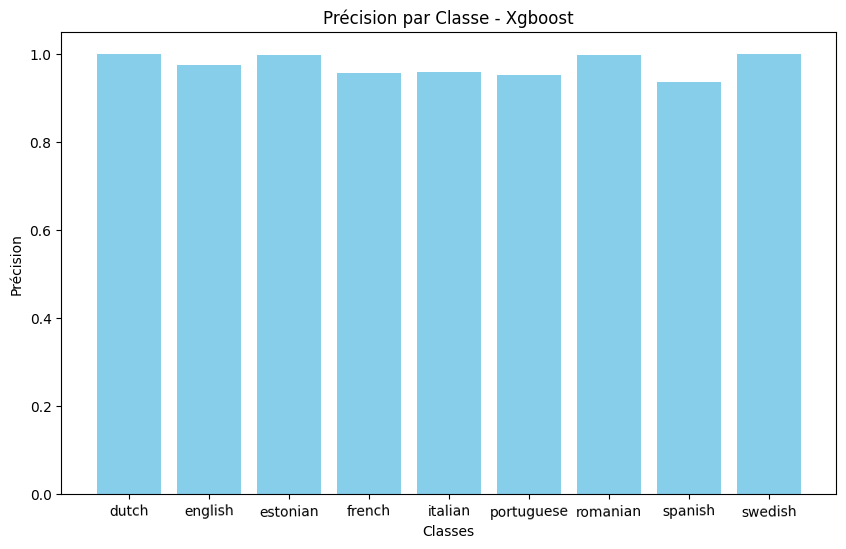

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de Confusion - Xgboost')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

class_precisions = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)['weighted avg']['precision']
classes = label_encoder.classes_
# Visualisation de la précision par classe
plt.figure(figsize=(10, 6))
plt.bar(classes, [classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)[cls]['precision'] for cls in classes], color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Précision")
plt.title("Précision par Classe - Xgboost")
plt.xticks(rotation=1)
plt.show()

## **KNN**

### **sans paramétres**

**initialisation du modèle**

In [72]:
knn = KNeighborsClassifier()

**entrainement du modèle**

In [73]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

**calcul et affichage de l'accuracy du train**

In [74]:
accyracyt=knn.score(X_train, y_train)

In [75]:
accuracyt

0.995970543281923

**Prédiction sur les données du test**

In [76]:
y_pred =knn.predict(X_test)

In [77]:
accuracy = accuracy_score(y_test, y_pred)

In [78]:
accuracy

0.49319255348707974

**Évaluation des performances du modèle k-NN  avec précision et rapport de classification**

In [79]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       400
           1       0.95      0.29      0.45       399
           2       1.00      0.55      0.71       400
           3       0.85      0.29      0.44       400
           4       0.25      0.73      0.37       400
           5       0.26      0.79      0.39       400
           6       1.00      0.39      0.56       400
           7       0.86      0.17      0.28       400
           8       1.00      0.64      0.78       400

    accuracy                           0.49      3599
   macro avg       0.80      0.49      0.52      3599
weighted avg       0.80      0.49      0.52      3599



**Calcul et affichage de la précision pour chaque classe**

In [80]:
cm = confusion_matrix(y_test, y_pred)

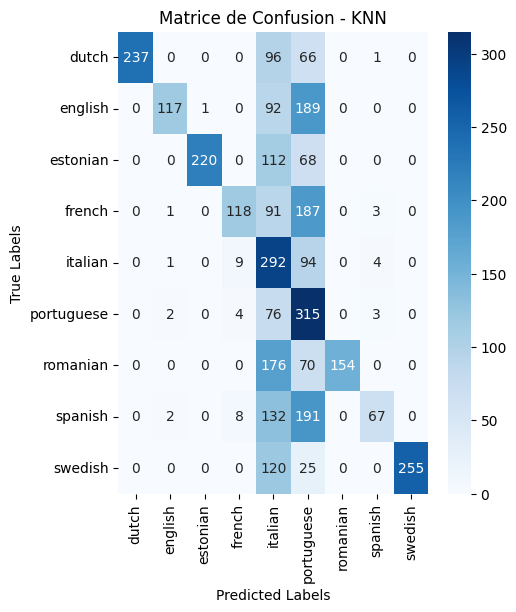

In [81]:
plt.figure(figsize=(5, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice de Confusion - KNN')
plt.show()

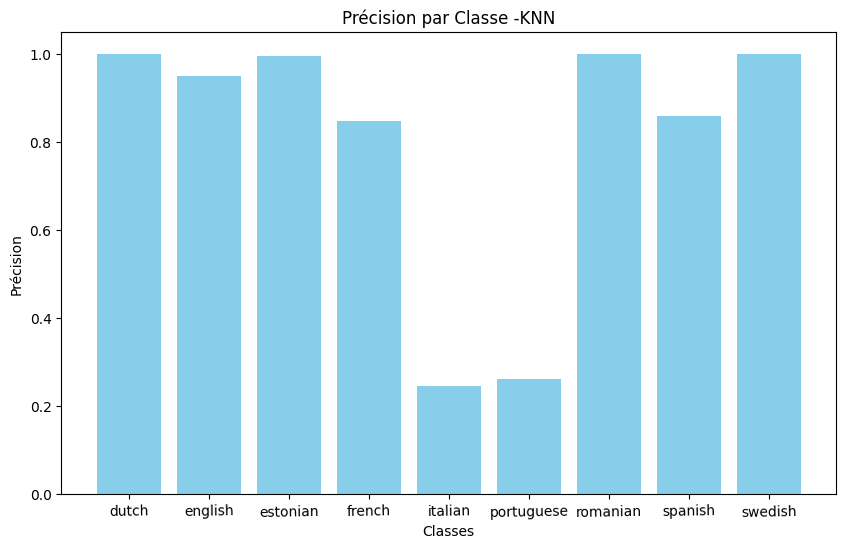

In [82]:

class_precisions = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)['weighted avg']['precision']
classes = label_encoder.classes_
# Visualisation de la précision par classe
plt.figure(figsize=(10, 6))
plt.bar(classes, [classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)[cls]['precision'] for cls in classes], color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Précision")
plt.title("Précision par Classe -KNN")
plt.xticks(rotation=1)
plt.show()

### **Avec hyperparamétres**

**Réduction des dimensions**

In [5]:
n_components = 100  
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

**Initialisation du modèle**

In [6]:
knn = KNeighborsClassifier()

**Configuration des hyperparamètres**

In [7]:
param_grid = {
    'n_neighbors': [10,15,20,30],  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']  
}

**Initialisation de la recherche en grille pour optimiser les hyperparamètres du modèle k-NN**

In [8]:
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # Validation croisée
    n_jobs=-1
)

**Entraînement de la recherche en grille sur les données PCA réduites**

In [9]:
grid_search.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [10, 15, 20, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

**Affichage des meilleurs paramètres**

In [10]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}

**Sélection du meilleur modèle k-NN et prédiction sur les données test**

In [11]:
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)

**Évaluation des performances du modèle k-NN optimal avec précision et rapport de classification**

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9461
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.97      0.95      0.96       399
           2       0.99      1.00      0.99       400
           3       0.95      0.90      0.92       400
           4       0.85      0.91      0.88       400
           5       0.90      0.94      0.92       400
           6       0.97      1.00      0.99       400
           7       0.91      0.83      0.87       400
           8       1.00      1.00      1.00       400

    accuracy                           0.95      3599
   macro avg       0.95      0.95      0.95      3599
weighted avg       0.95      0.95      0.95      3599



**Calcul et affichage de la précision pour chaque classe**

In [14]:
cm = confusion_matrix(y_test, y_pred)

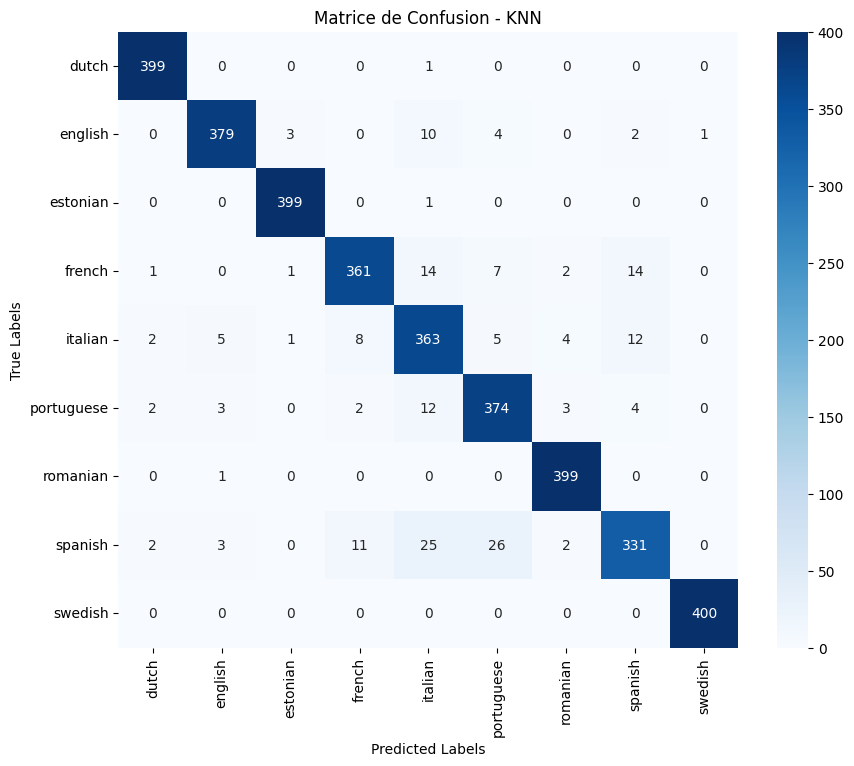

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice de Confusion - KNN')
plt.show()

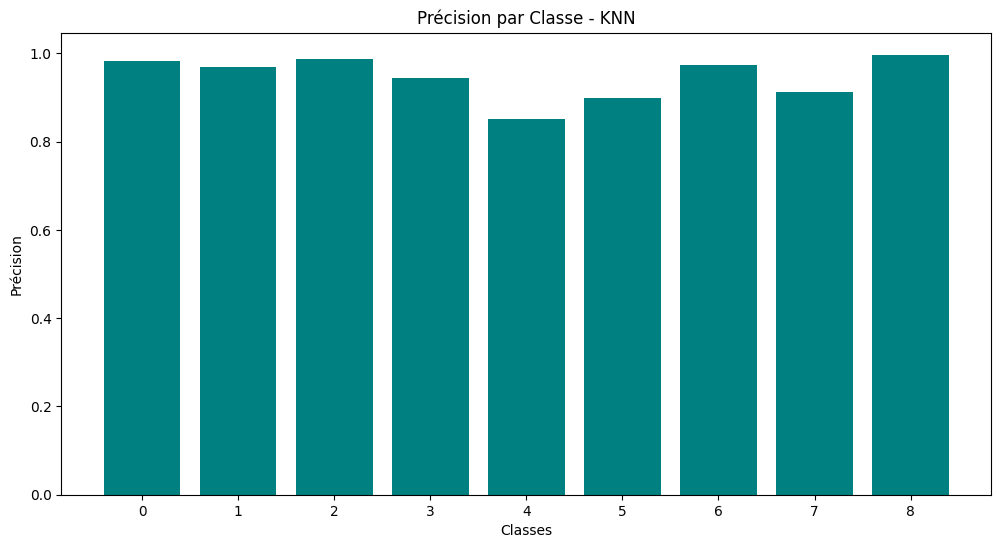

In [17]:
report = classification_report(y_test, y_pred, output_dict=True)
classes = list(report.keys())[:-3]  # Exclure les moyennes globales (accuracy, macro avg, weighted avg)
precisions = [report[cls]['precision'] for cls in classes]

# Afficher un graphique des précisions par classe
plt.figure(figsize=(12, 6))
plt.bar(classes, precisions, color='teal')
plt.xlabel('Classes')
plt.ylabel('Précision')
plt.title('Précision par Classe - KNN')
plt.xticks(rotation=1)
plt.show()


## **Arbre de Décision**

### **sans paramétres**

**initialisation du modéle**

In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)

**Entrainement du modéle**

In [8]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**calcul et affichage du score de train**

In [9]:
accuracyt=tree_clf.score(X_train, y_train)

In [10]:
accuracyt

0.996178963456996

**Prédiction du modéle sur les données du tests**

In [11]:
y_pred = tree_clf.predict(X_test)


**Évaluation des performances du modèle avec précision et rapport de classification**

In [12]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [13]:
accuracy

0.936649069185885

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.95      0.92      0.94       399
           2       0.98      0.98      0.98       400
           3       0.94      0.85      0.90       400
           4       0.81      0.93      0.86       400
           5       0.91      0.93      0.92       400
           6       0.97      0.98      0.98       400
           7       0.89      0.83      0.86       400
           8       1.00      1.00      1.00       400

    accuracy                           0.94      3599
   macro avg       0.94      0.94      0.94      3599
weighted avg       0.94      0.94      0.94      3599



In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)

**Calcul et affichage de la précision pour chaque classe**

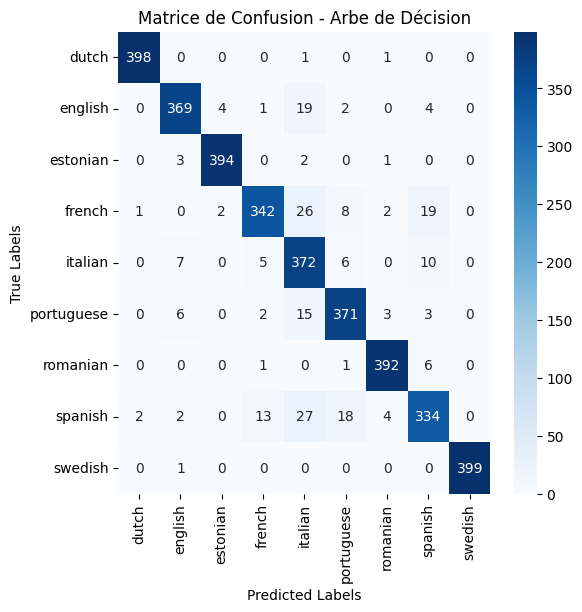

In [16]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice de Confusion - Arbe de Décision')
plt.show()

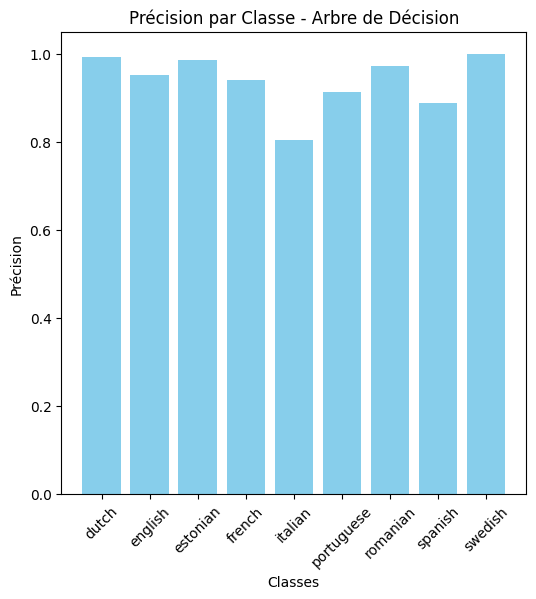

In [17]:
class_precisions = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)['weighted avg']['precision']
classes = label_encoder.classes_
# Visualisation de la précision par classe
plt.figure(figsize=(6, 6))
plt.bar(classes, [classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)[cls]['precision'] for cls in classes], color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Précision")
plt.title("Précision par Classe - Arbre de Décision")
plt.xticks(rotation=45)
plt.show()

**Configuration des hyperparamètres**

In [80]:
param_dist = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2,4,6,9,10],
    'min_samples_leaf': [1,3,5,8,10,15],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

**Initialisation du modèle**

In [81]:
tree_clf = DecisionTreeClassifier(random_state=42)


**Initialisation de la recherche en grille pour optimiser les hyperparamètres du modèle**

In [82]:
random_search = RandomizedSearchCV(tree_clf, param_distributions=param_dist, n_iter=20, 
                                   cv=3, scoring='accuracy', random_state=42)


**Entraînement de la recherche en grille sur les données du train**

In [83]:
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 15, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5, 8, 10,
                                                             15],
                                        'min_samples_split': [2, 4, 6, 9, 10]},
                   random_state=42, scoring='accuracy')

**Affichage des meilleurs paramètres**

In [84]:
random_search.best_params_

{'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'gini'}

**Sélection du meilleur modèle et prédiction sur les données test**

In [85]:
y_pred = random_search.best_estimator_.predict(X_test)


**Évaluation des performances du modèle avec précision et rapport de classification**

In [86]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [87]:
accuracy

0.9146985273687135

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.94      0.88      0.91       399
           2       0.99      0.99      0.99       400
           3       0.89      0.89      0.89       400
           4       0.81      0.85      0.83       400
           5       0.81      0.88      0.84       400
           6       0.99      0.97      0.98       400
           7       0.84      0.79      0.81       400
           8       0.99      1.00      0.99       400

    accuracy                           0.91      3599
   macro avg       0.92      0.91      0.91      3599
weighted avg       0.92      0.91      0.91      3599



**Calcul et affichage de la précision pour chaque classe**

In [89]:
conf_matrix = confusion_matrix(y_test, y_pred)

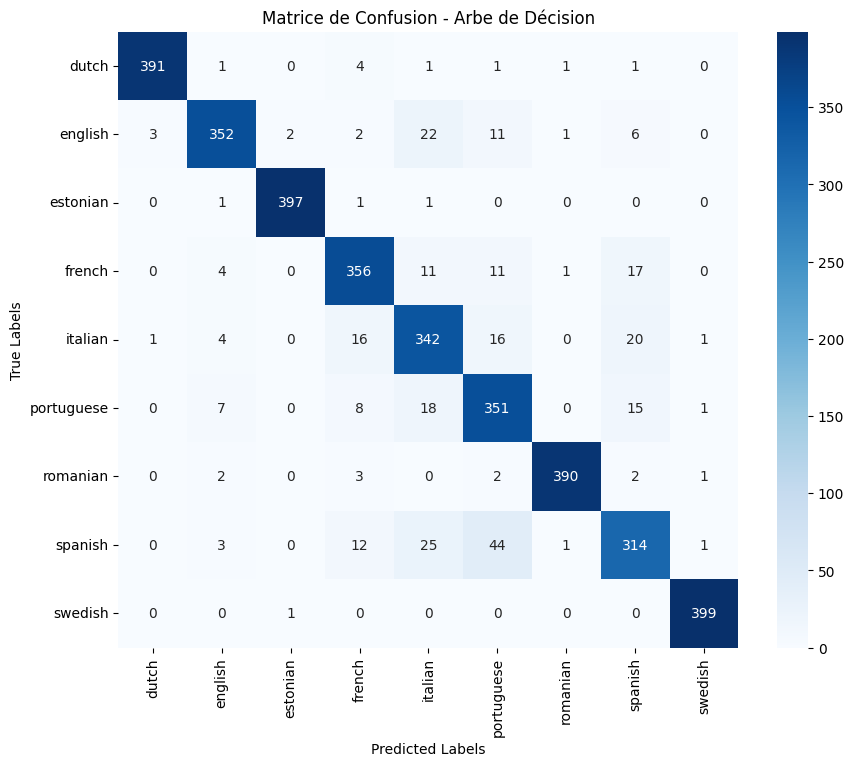

In [90]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice de Confusion - Arbe de Décision')
plt.show()

## **réseau de neuron**

### *sans paramètres*

**initialiser le modèle**

In [64]:
mlp = MLPClassifier(random_state=42)

**Entraînement du modèle**

In [65]:
mlp.fit(X_train, y_train)


MLPClassifier(random_state=42)

**accuracy de train**

In [66]:
accuracyt=mlp.score(X_train, y_train)


In [67]:
accuracyt

0.995970543281923

**prédiction sur les données test**

In [68]:
y_pred = mlp.predict(X_test)

**Évaluation des performances du modèle avec précision et rapport de classification**

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9705
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.97      0.98      0.98       399
           2       1.00      1.00      1.00       400
           3       0.97      0.96      0.96       400
           4       0.94      0.94      0.94       400
           5       0.93      0.94      0.94       400
           6       1.00      1.00      1.00       400
           7       0.93      0.92      0.93       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul et affichage de la précision pour chaque classe**

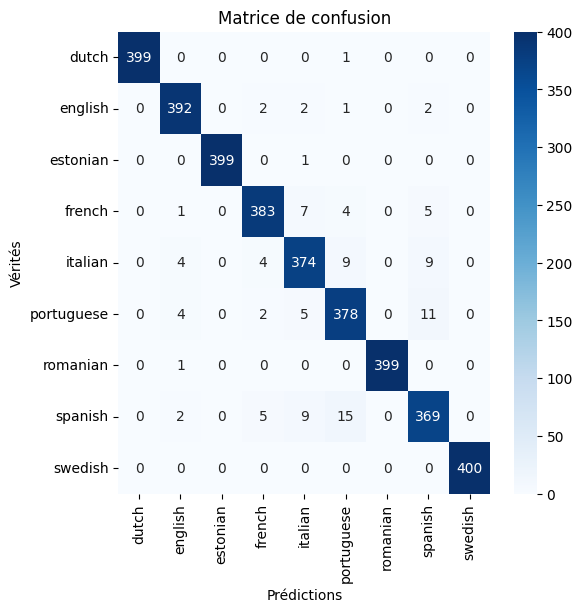

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()


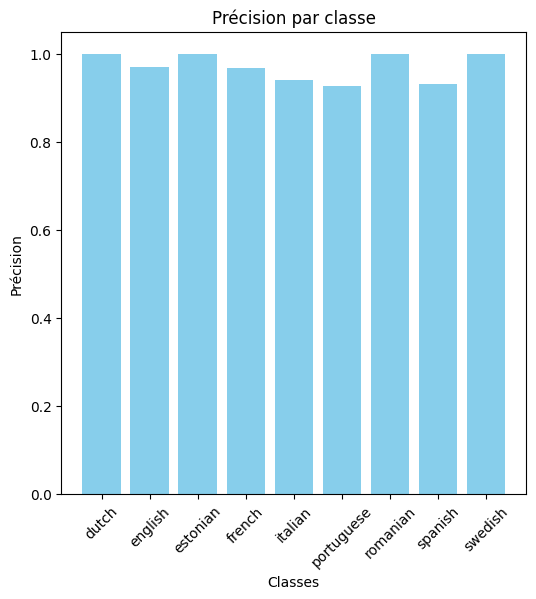

In [71]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = [report[class_name]["precision"] for class_name in label_encoder.classes_]
plt.figure(figsize=(6, 6))
plt.bar(label_encoder.classes_, precision_per_class, color='skyblue')
plt.title("Précision par classe")
plt.xlabel("Classes")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.show()

### **avec hyperparamétres**

**Réduction des dimensions**

In [14]:
n_components = 200  
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

**Initialisation du modèle**

In [15]:
mlp = MLPClassifier(max_iter=500, random_state=42)

**Configuration des hyperparamètres**

In [16]:
param_distributions = {
    'hidden_layer_sizes': [(512, 256, 128), (256, 128, 64), (128, 64, 32)],  
    'activation': ['relu', 'tanh'],  
    'solver': ['adam', 'sgd'], 
    'alpha': [0.0001, 0.001, 0.01], 
    'learning_rate': ['constant', 'adaptive'],  
}

**Initialisation de la recherche en grille pour optimiser les hyperparamètres du modèle**

In [17]:
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_distributions,
    n_iter=10,  
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


**Entraînement de la recherche en grille sur les données PCA réduites**

In [18]:
random_search.fit(X_train_pca, y_train)


RandomizedSearchCV(cv=5, estimator=MLPClassifier(max_iter=500, random_state=42),
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(512, 256, 128),
                                                               (256, 128, 64),
                                                               (128, 64, 32)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='accuracy')

**Affichage des meilleurs paramètres**

In [19]:
random_search.best_params_

{'solver': 'adam',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (128, 64, 32),
 'alpha': 0.01,
 'activation': 'relu'}

**Sélection du meilleur modèle et prédiction sur les données test**

In [20]:
y_pred = random_search.best_estimator_.predict(X_test_pca)

**Évaluation des performances du modèle avec précision et rapport de classification**

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9697
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       0.98      0.97      0.97       399
           2       0.99      0.99      0.99       400
           3       0.94      0.96      0.95       400
           4       0.95      0.94      0.95       400
           5       0.96      0.93      0.94       400
           6       0.99      1.00      0.99       400
           7       0.91      0.94      0.92       400
           8       1.00      1.00      1.00       400

    accuracy                           0.97      3599
   macro avg       0.97      0.97      0.97      3599
weighted avg       0.97      0.97      0.97      3599



**Calcul et affichage de la précision pour chaque classe**

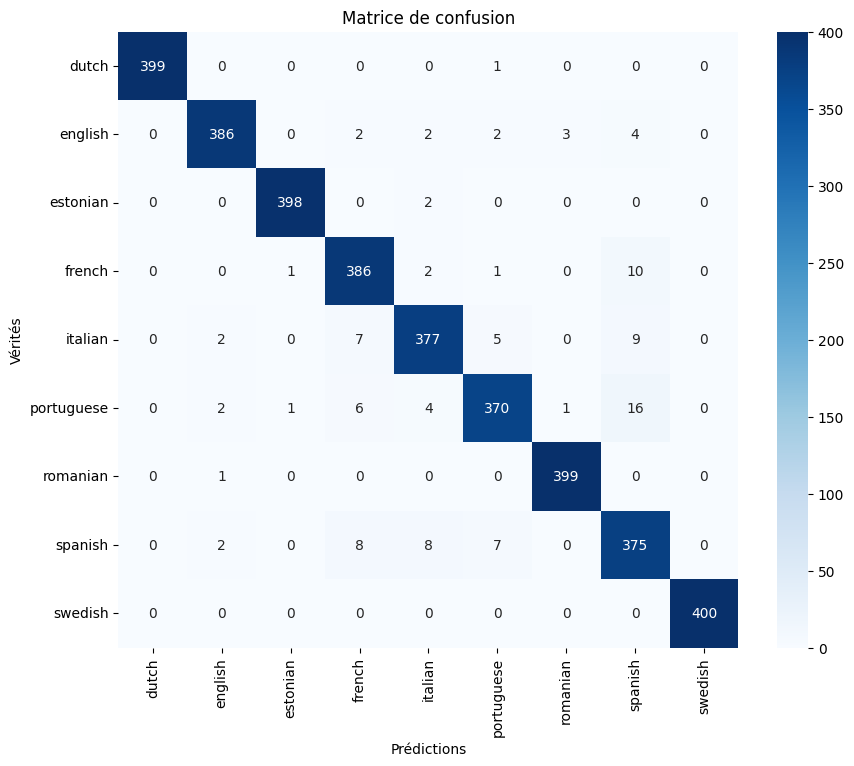

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()


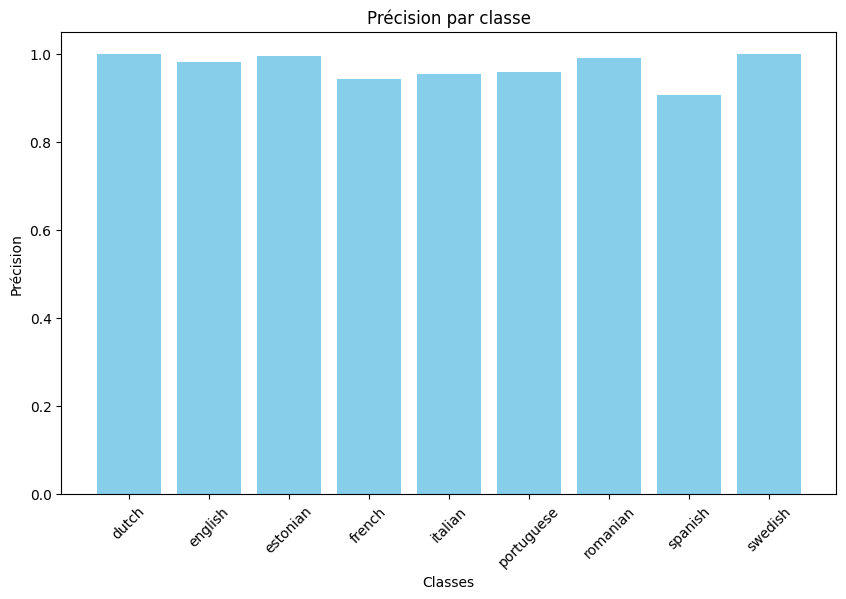

In [25]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
precision_per_class = [report[class_name]["precision"] for class_name in label_encoder.classes_]
plt.figure(figsize=(10, 6))
plt.bar(label_encoder.classes_, precision_per_class, color='skyblue')
plt.title("Précision par classe")
plt.xlabel("Classes")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.show()


### **Comparaison des modeles en se basant sur l'accuracy avac réglage des paramétres**

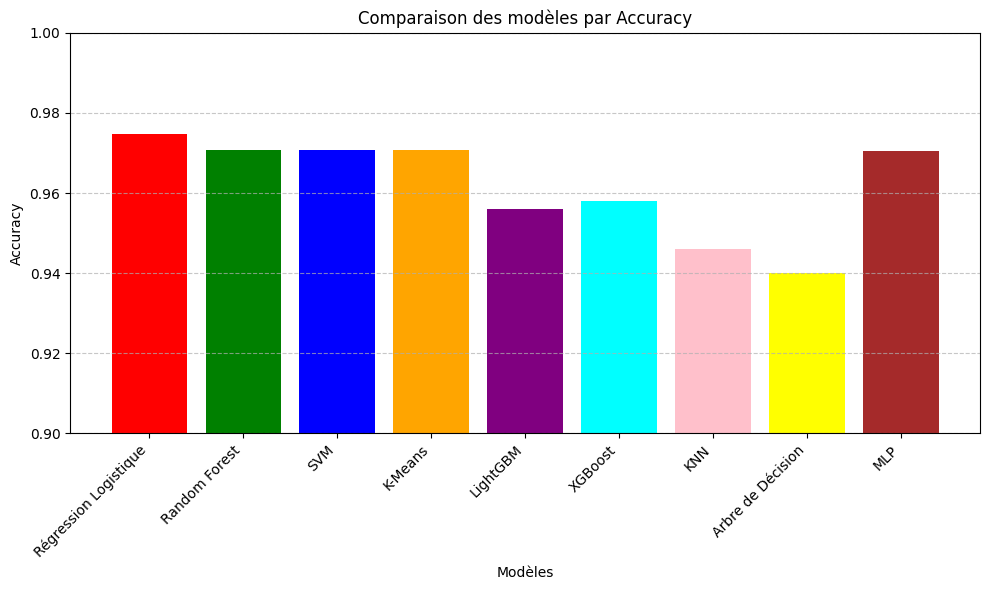

In [107]:
import matplotlib.pyplot as plt

# Données
model_names = [
    "Régression Logistique", "Random Forest", "SVM", "K-Means", 
    "LightGBM", "XGBoost", "KNN", "Arbre de Décision", "MLP"
]
accuracies = [0.9747, 0.9708, 0.9708, 0.9708, 0.9561, 0.9580, 0.9461, 0.9400, 0.9705]

# Couleurs pour chaque modèle
colors = [
    "red", "green", "blue", "orange", 
    "purple", "cyan", "pink", "yellow", "brown"
]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=colors)
plt.xlabel("Modèles")
plt.ylabel("Accuracy")
plt.title("Comparaison des modèles par Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.9, 1.0)  # Pour mieux visualiser les différences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### **Comparaison des modeles en se basant sur l'accuracy après réglage des paramétres**

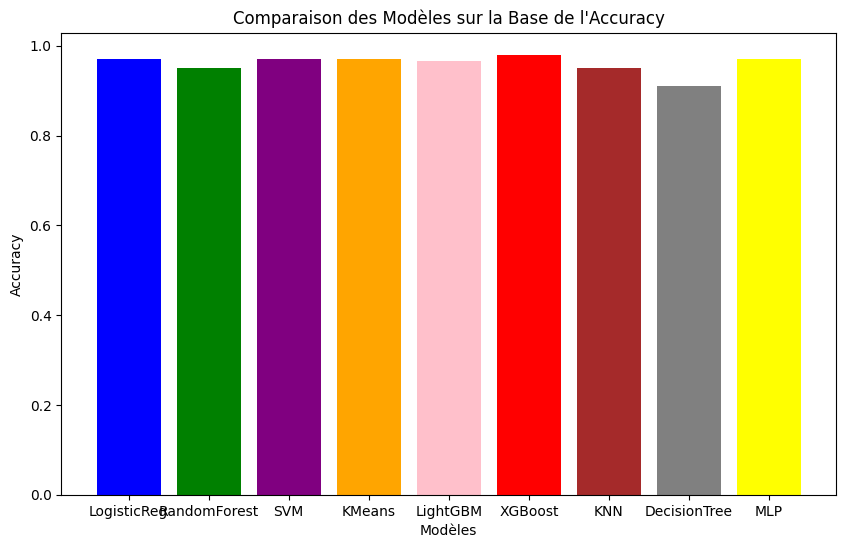

In [109]:
results_accuracy = {
    'LogisticReg': 0.9700,
    'RandomForest': 0.9500,
    'SVM': 0.9700,
    'KMeans': 0.9700,
    'LightGBM': 0.9659,
    'XGBoost': 0.9800,
    'KNN': 0.9500,
    'DecisionTree': 0.9100,
    'MLP': 0.9700
}
colors = {
    'LogisticReg': 'blue',
    'RandomForest': 'green',
    'SVM': 'purple',
    'KMeans': 'orange',
    'LightGBM': 'pink',
    'XGBoost': 'red',
    'KNN': 'brown',
    'DecisionTree': 'grey',
    'MLP': 'yellow'
}
plt.figure(figsize=(10, 6))
plt.bar(results_accuracy.keys(), results_accuracy.values(), color=[colors[key] for key in results_accuracy.keys()])
plt.xlabel('Modèles')
plt.ylabel('Accuracy')
plt.title('Comparaison des Modèles sur la Base de l\'Accuracy')
plt.show()
